In [155]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [156]:
file_path = "/aiffel/aiffel/translator_seq2seq/data/"
data = pd.read_csv(file_path + "fra.txt", names=['eng', 'fra', 'cc'], sep="\t")

data = data.sample(33000)

In [210]:
eng = data["eng"]
fra = data["fra"]

In [203]:
english = []
french = []

def preprocessing(sentences):
    s = []
    for sentence in sentences:
        temp = sentence.replace(",", " ,")
        temp = temp.replace(".", " .")
        temp = temp.replace("?", " ?")
        temp = temp.replace("!", " !")
        temp.lower()
        temp = "<sos> " + temp + " <eos>"
    s.append(temp)
    return s

english = preprocessing(eng)
french = preprocessing(fra)

['<sos> Pour me a glass of wine . <eos>']


In [160]:
eng_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=" ")
fre_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=" ")

eng_tokenizer.fit_on_texts(english)
fre_tokenizer.fit_on_texts(french)

encoder_input = eng_tokenizer.texts_to_sequences(english)

french_tokens = fre_tokenizer.texts_to_sequences(french)
decoder_input = [[s for s in sentence if s != fre_tokenizer.word_index["<eos>"]] for sentence in french_tokens]
decoder_output = [[s for s in sentence if s != fre_tokenizer.word_index["<sos>"]] for sentence in french_tokens]

In [161]:
encoder_input = tf.keras.preprocessing.sequence.pad_sequences(encoder_input, padding="post")
decoder_input = tf.keras.preprocessing.sequence.pad_sequences(decoder_input, padding="post")
decoder_output = tf.keras.preprocessing.sequence.pad_sequences(decoder_output, padding="post")

In [162]:
train_size = 30000

train_encoder_input = encoder_input[:train_size]
train_decoder_input = decoder_input[:train_size]
train_decoder_output = decoder_output[:train_size]

test_encoder_input = encoder_input[train_size:]
test_decoder_input = decoder_input[train_size:]
test_decoder_output = decoder_output[train_size:]

In [163]:
encoder_word_size = len(eng_tokenizer.word_index)+1
encoder_maxlen = train_encoder_input.shape[1]
decoder_word_size = len(fre_tokenizer.word_index)+1
decoder_maxlen = train_decoder_input.shape[1]
word_dim = 512

Epoch 1/20
118/118 [==============================] - 43s 347ms/step - loss: 1.2221 - val_loss: 0.8721
Epoch 2/20
118/118 [==============================] - 40s 335ms/step - loss: 0.8171 - val_loss: 0.7806
Epoch 3/20
118/118 [==============================] - 40s 339ms/step - loss: 0.7423 - val_loss: 0.7303
Epoch 4/20
118/118 [==============================] - 40s 338ms/step - loss: 0.6844 - val_loss: 0.6863
Epoch 5/20
118/118 [==============================] - 40s 339ms/step - loss: 0.6304 - val_loss: 0.6421
Epoch 6/20
118/118 [==============================] - 40s 340ms/step - loss: 0.5868 - val_loss: 0.6187
Epoch 7/20
118/118 [==============================] - 40s 341ms/step - loss: 0.5525 - val_loss: 0.6026
Epoch 8/20
118/118 [==============================] - 40s 340ms/step - loss: 0.5223 - val_loss: 0.5855
Epoch 9/20
118/118 [==============================] - 40s 340ms/step - loss: 0.4947 - val_loss: 0.5755
Epoch 10/20
118/118 [==============================] - 40s 340ms/step - l

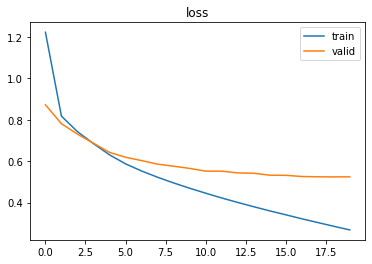

In [169]:
encoder_inputs = tf.keras.layers.Input(shape=(None, ))
encoder_embedding = tf.keras.layers.Embedding(encoder_word_size, word_dim)(encoder_inputs)
_, state_h, state_c = tf.keras.layers.LSTM(512, return_state=True)(encoder_embedding)
encoder_state = [state_h, state_c]

decoder_inputs = tf.keras.layers.Input(shape=(None, ))
decoder_embedding = tf.keras.layers.Embedding(decoder_word_size, word_dim)(decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM(512, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_state)
decoder_softmax = tf.keras.layers.Dense(decoder_word_size, activation="softmax")
decoder_outputs = decoder_softmax(decoder_outputs)

model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

history = model.fit(x=[train_encoder_input, train_decoder_input], 
                    y=train_decoder_output, 
                    validation_data=([test_encoder_input, test_decoder_input], test_decoder_output),
                    batch_size=256,
                    epochs=20)

loss = history.history["loss"]
valid_loss = history.history["val_loss"]

plt.plot(loss, label="train")
plt.plot(valid_loss, label="valid")
plt.title("loss")
plt.legend()
plt.show()


In [173]:
encoder_model = tf.keras.Model(inputs = encoder_inputs, outputs = encoder_state)

In [174]:
decoder_state_input_h = tf.keras.Input(shape=(512,))
decoder_state_input_c = tf.keras.Input(shape=(512,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state = decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_softmax(decoder_outputs)

decoder_model = tf.keras.Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)

In [204]:
def decode_sequence(input_sentence):
    input_sentence = preprocessing([input_sentence])
    input_sentence = eng_tokenizer.texts_to_sequences(input_sentence)
    input_sentence = tf.keras.preprocessing.sequence.pad_sequences(input_sentence, padding="post", maxlen = encoder_maxlen)
    states_value = encoder_model.predict(input_sentence)
    
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = eng_tokenizer.word_index["<sos>"]
    
    flag = True
    decoded_sentence = ""
    while flag:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = fre_tokenizer.index_word[sampled_token_index]

        decoded_sentence += ' ' + sampled_token

        if sampled_token == "<eos>":
            flag = False
  
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        states_value = [h, c]

    return decoded_sentence[:-6]

In [209]:
print(decode_sequence("i love you"))
print(decode_sequence("i will find you"))
print(decode_sequence("i'm so glad to meet you"))
print(decode_sequence("you are right"))
print(decode_sequence("they stopped doing that"), "### train dataset ###")
print(decode_sequence("Sorry, I didn't mean to scare you"), "### train dataset ###")

 à toi .
 je vous aime .
 je suis contente que vous soyez là .
 vous êtes fort .
 ils ont dit que c'était urgent . ### train dataset ###
 désolée , je ne t'ai pas entendu . ### train dataset ###
